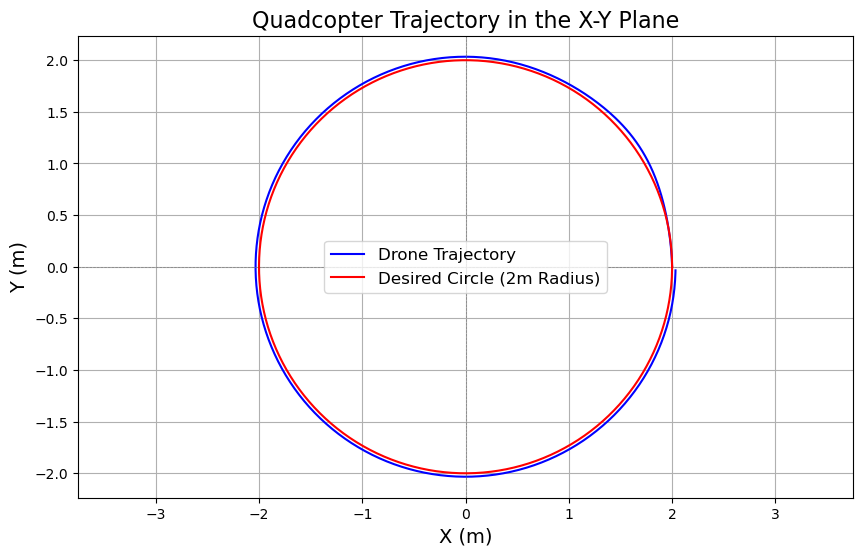

In [98]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Constants
m = 1.082  # mass of the quadcopter (kg)
g = 9.81  # gravitational acceleration (m/s^2)
Ixx = 4.856 * 1e-2  # Moment of inertia around x-axis (kg*m^2)
Iyy = 4.856 * 1e-2  # Moment of inertia around y-axis (kg*m^2)
Izz = 8.801 * 1e-2
K = 2.58 * 1e-8  # thrust coefficient (N per motor speed squared)
l = 0.1225  # arm length (m)
b = 1.14 * 1e-7  # drag coefficient
A_x = 0.25  # drag coefficient along x-axis
A_y = 0.25  # drag coefficient along y-axis
A_z = 0.25  # drag coefficient along z-axis

# Circle parameters
radius = 2  # radius of the circle (meters)
T = 20  # time to complete one circle (seconds)
omega_circle = 2 * np.pi / T  # angular velocity for circular motion (rad/s)

# Calculate the motor speed required for hover
def calculate_hover_omega(mass, g, K):
    required_thrust = mass * g
    omega_hover = np.sqrt(required_thrust / (4 * K))
    return omega_hover

# Use the calculated omega_hover for all motors in hover
omega_hover = calculate_hover_omega(m, g, K)

# Define the system of differential equations
def eom_circular(t, state, params):
    # Unpack the state variables
    x, y, z, vx, vy, vz, phi, theta, psi, phidot, thetadot, psidot = state
    
    # Unpack parameters
    m, Ixx, Iyy, Izz, K, l, b, A_x, A_y, A_z, omega1, omega2, omega3, omega4, g, omega_circle, radius = params
    
    # Desired position and velocity for circular motion
    x_d = radius * np.cos(omega_circle * t)
    y_d = radius * np.sin(omega_circle * t)
    vx_d = -radius * omega_circle * np.sin(omega_circle * t)
    vy_d = radius * omega_circle * np.cos(omega_circle * t)
    
    # Errors in position and velocity
    ex = x_d - x
    ey = y_d - y
    evx = vx_d - vx
    evy = vy_d - vy

    # Proportional-Derivative (PD) control for roll and pitch
    Kp = 0.5 # Proportional gain
    Kd = 0.2  # Derivative gain
    theta_command = Kp * ex + Kd * evx  # Pitch control
    phi_command = Kp * ey + Kd * evy    # Roll control
    
    # Bound phi and theta for safety
    phi = np.clip(phi_command, -np.pi/6, np.pi/6)
    theta = np.clip(theta_command, -np.pi/6, np.pi/6)
    
    # Total thrust term (sum of squared angular velocities)
    total_thrust = omega1**2 + omega2**2 + omega3**2 + omega4**2

    # Translational accelerations
    ax = -A_x * vx + K * np.sin(theta) * total_thrust
    ay = -A_y * vy + K * np.sin(phi) * total_thrust
    az = -A_z * vz - K * np.cos(phi) * np.cos(theta) * total_thrust + m * g
    
    # Rotational accelerations
    phiddot = 0  # Simplified control for circular motion
    thetaddot = 0
    psiddot = 0  # Assuming no yaw angular acceleration
    
    return [
        vx,  # dx/dt
        vy,  # dy/dt
        vz,  # dz/dt
        ax,  # dvx/dt
        ay,  # dvy/dt
        az,  # dvz/dt
        phidot,  # dphi/dt
        thetadot,  # dtheta/dt
        psidot,  # dpsi/dt
        phiddot,  # dphidot/dt
        thetaddot,  # dthetadot/dt
        psiddot   # dpsidot/dt
    ]

# Initial conditions
initial_conditions = [2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Parameters
params = [m, Ixx, Iyy, Izz, K, l, b, A_x, A_y, A_z, omega_hover, omega_hover, omega_hover, omega_hover, g, omega_circle, radius]

# Time span for simulation
t_span = (0, T)  # Simulate for one circle
t_eval = np.linspace(0, T, 500)

# Solve the ODE
sol = solve_ivp(eom_circular, t_span, initial_conditions, args=(params,), t_eval=t_eval)

# Plot the quadcopter trajectory in the x-y plane
plt.figure(figsize=(10, 6))
plt.plot(sol.y[0], sol.y[1], label="Drone Trajectory", color="blue")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)

# Overlay the desired circular trajectory
circle_x = radius * np.cos(omega_circle * sol.t)
circle_y = radius * np.sin(omega_circle * sol.t)
plt.plot(circle_x, circle_y, 'r-', label="Desired Circle (2m Radius)")

plt.title("Quadcopter Trajectory in the X-Y Plane", fontsize=16)
plt.xlabel("X (m)", fontsize=14)
plt.ylabel("Y (m)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.axis("equal")  # Equal scaling for x and y axes
plt.show()
